In [0]:
#import of libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image

import json 

import time


#Image classifier to recognize different kind of flowers 
#Dataset of 102 flower categories





## Step 1: Load Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_dir = '/content/drive/My Drive/Colab Notebooks/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

We need to load in a mapping from category label to category name
This is JSON object which can be read in with the json module

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

## Step 2: Transform the Dataset

In [0]:
#Define transforms for the training, validation, and testing sets
#For the training, we need to apply transformations such as random scaling, cropping, and flipping
#This will help the network leading to better performance
#Data resized to 224x224 pixels as required by the pre-trained networks


#Validation and testing sets are used to measure the model's performance on data it hasn't seen yet

data_transforms ={
'train_transforms':transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),

'test_transforms' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

'validation_transforms' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])}
# loading the datasets with ImageFolder
image_datasets = {'train_data' : datasets.ImageFolder(data_dir + '/train', transform=data_transforms['train_transforms']),
'test_data' : datasets.ImageFolder(data_dir + '/test', transform=data_transforms['test_transforms']),
'valid_data' : datasets.ImageFolder(data_dir + '/valid', transform=data_transforms['validation_transforms'])
                 }

# definining the dataloaders
dataloaders = {'trainloader' : torch.utils.data.DataLoader(image_datasets['train_data'], batch_size=64, shuffle=True),
'testloader' : torch.utils.data.DataLoader(image_datasets['test_data'], batch_size=32),
'validloader' : torch.utils.data.DataLoader(image_datasets['valid_data'], batch_size=32)}

## Step 3: Create Model

In [0]:
#I will use the vgg16 architecture, which we can obtain from the torchvision library
arch = {"vgg16":25088,
        "densenet121":1024
        }

In [0]:
def network_construct(structure='vgg16',dropout=0.5, hidden_layer1 = 4096,lr = 0.001):
    
    
    if structure == 'vgg16':
        model = models.vgg16(pretrained=True)
        
    elif structure == 'densenet121':
        model = models.densenet121(pretrained=True)
    
    else:
        print("Please try for vgg16 or densenet121")
        
    
        
    for param in model.parameters():
        param.requires_grad = False
    #activation functions    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(arch[structure],hidden_layer1)),
                          ('relu1', nn.ReLU()),
                          ('d_out1',nn.Dropout(dropout)),
                          ('fc2', nn.Linear(hidden_layer1, 1024)),
                          ('relu2', nn.ReLU()),
                          ('d_out2',nn.Dropout(dropout)),
                          ('fc3', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
        
        
    model.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr )
    model.cuda()
        
    return model, optimizer ,criterion

In [0]:
model,optimizer,criterion = network_construct('vgg16')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


## Step 4: Train Network


In [0]:
#  network train
def do_deep_learning(model, trainloader, epochs, print_every, criterion, optimizer, device='cpu'):
    print_every = print_every
    steps = 0

    # change to cuda
    model.to('cuda')

    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
            # Change images and labels to work with cuda
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                v_lost = 0
                v_accuracy=0
                for ii, (inputs2,labels2) in enumerate(dataloaders['validloader']):
                    optimizer.zero_grad()
                    inputs2, labels2 = inputs2.to('cuda') , labels2.to('cuda')
                    model.to('cuda')
                    with torch.no_grad():    
                        outputs = model.forward(inputs2)
                        v_lost = criterion(outputs,labels2)
                        ps = torch.exp(outputs).data
                        equality = (labels2.data == ps.max(1)[1])
                        v_accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
                v_lost = v_lost / len(dataloaders['validloader'])
                v_accuracy = v_accuracy /len(dataloaders['validloader'])
            
                print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Lost {:.4f}".format(v_lost),
                   "Accuracy: {:.4f}".format(v_accuracy))
                running_loss = 0

    
    
do_deep_learning(model, dataloaders['trainloader'],1, 40, criterion, optimizer, 'gpu')

Epoch: 1/1...  Loss: 4.4029 Validation Lost 0.1290 Accuracy: 0.3408
Epoch: 1/1...  Loss: 2.3116 Validation Lost 0.0886 Accuracy: 0.6131


## Step 5: Save the Model


In [0]:
model.class_to_idx =  image_datasets['train_data'].class_to_idx
model.cpu
torch.save({'structure' :'vgg16',
            'hidden_layer1': 4096,
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx},
            'checkpoint.pth')


# Step 6: Load the Model



In [0]:
def load_model(path):
    checkpoint = torch.load('checkpoint.pth')
    structure = checkpoint['structure']
    hidden_layer1 = checkpoint['hidden_layer1']
    model,_,_ = network_construct(structure , 0.5,hidden_layer1)
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model
    
model=load_model('checkpoint.pth')  
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
def process_image(image):
    proc_img = Image.open(image)
   
    prepoceess_img = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
        
    #Process image for use in a PyTorch model
    pymodel_img = prepoceess_img(proc_img)
    return pymodel_img

## Class Prediction

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

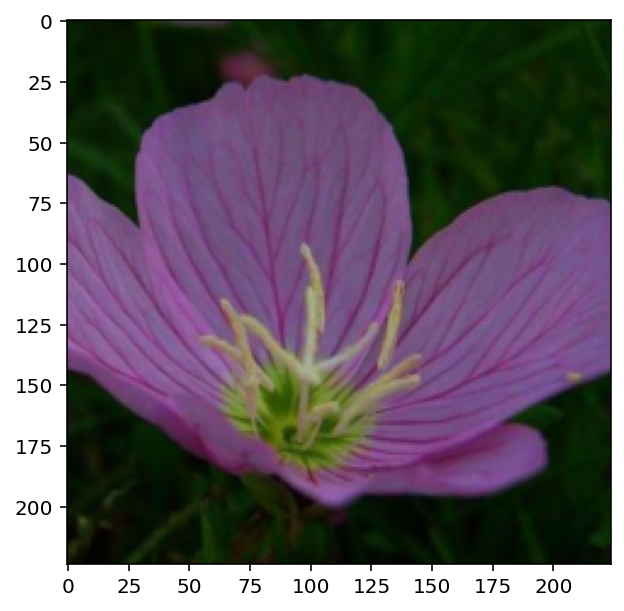

In [0]:
imshow(process_image("/content/drive/My Drive/Colab Notebooks/flower_data/test/1/image_06752.jpg"))


In [0]:
def predict(image_path, model, topk=5):   
    model.to('cuda')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)

In [0]:
def check():
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = 1
    path = '/content/drive/My Drive/Colab Notebooks/flower_data/test/1/image_06752.jpg'

    probabilities = predict(path, model)
    image = process_image(path)
    probabilities = probabilities
    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index+1)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    
    plt.show()

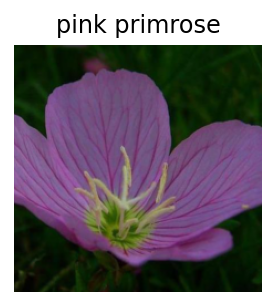

TypeError: ignored

In [0]:
check()